In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional
import numbers

# Read data

In [2]:
DATA_FOLDER = "../data/raw/"

df_ratings = pd.read_csv(
    os.path.join(DATA_FOLDER, 'BX-Book-Ratings.csv'), 
    sep=";",
    encoding_errors="replace")
df_books = pd.read_csv(
    os.path.join(DATA_FOLDER, 'BX-Books.csv'), 
    sep=";",
    encoding_errors="replace",
    on_bad_lines='skip')
df_users = pd.read_csv(
    os.path.join(DATA_FOLDER, 'BX-Users.csv'), 
    sep=";",
    encoding_errors="replace")

/tmp/ipykernel_15299/3992959908.py:7: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_books = pd.read_csv(


In [3]:
display(df_ratings.head(3))
print(df_ratings.shape)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0


(1149780, 3)


In [4]:
display(df_books.head(3))
print(df_books.shape)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...


(271360, 8)


In [5]:
display(df_users.head(3))
print(df_users.shape)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN


(278858, 3)


# Data preparation

In [6]:
def auto_opt_pd_dtypes(df_: pd.DataFrame, inplace=False) -> Optional[pd.DataFrame]:
    """ Automatically downcast Number dtypes for minimal possible,
        will not touch other (datetime, str, object, etc)
        
        :param df_: dataframe
        :param inplace: if False, will return a copy of input dataset
        
        :return: `None` if `inplace=True` or dataframe if `inplace=False`
    """
    df = df_ if inplace else df_.copy()
        
    for col in df.columns:
        # integers
        if issubclass(df[col].dtypes.type, numbers.Integral):
            # unsigned integers
            if df[col].min() >= 0:
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            # signed integers
            else:
                df[col] = pd.to_numeric(df[col], downcast='integer')
        # other real numbers
        elif issubclass(df[col].dtypes.type, numbers.Real):
            df[col] = pd.to_numeric(df[col], downcast='float')
    
    if not inplace:
        return df

## Ratings

In [7]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [8]:
df_ratings = df_ratings.rename(columns={
    'User-ID': 'user_id',
    'ISBN': 'isbn',
    'Book-Rating': 'rating'
})

We don't have any NaNs, let's apply data types optimization.

In [9]:
df_ratings = auto_opt_pd_dtypes(df_ratings)

In [10]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   user_id  1149780 non-null  uint32
 1   isbn     1149780 non-null  object
 2   rating   1149780 non-null  uint8 
dtypes: object(1), uint32(1), uint8(1)
memory usage: 14.3+ MB


26.3 -> 14.3 Mb

## Books

In [11]:
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [12]:
df_books = df_books.rename(columns={
    'ISBN': 'isbn',
    'Book-Title': 'title',
    'Book-Author': 'author',
    'Year-Of-Publication': 'year',
    'Publisher': 'publisher',
    'Image-URL-L': 'img_url'
    
})

In [13]:
df_books = df_books.drop(columns=['Image-URL-S', 'Image-URL-M'])

It's OK that we don't have all book covers image URLs, but let's check NaNs in authors and publishers.

In [14]:
df_books[df_books['author'].isna() | df_books['publisher'].isna()]

,isbn,title,author,year,publisher,img_url
118033,0751352497,A+ Quiz Masters:01 Earth,NaN,1999,Dorling Kindersley,http://images.amazon.com/images/P/0751352497.0...
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN,http://images.amazon.com/images/P/193169656X.0...
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN,http://images.amazon.com/images/P/1931696993.0...
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing,http://images.amazon.com/images/P/9627982032.0...


We will try to find these info later

Handling mixed data types in `year` column

In [15]:
string_val_amount = df_books['year'].apply(lambda x: isinstance(x, str)).sum()
print(f"Total amount of strings in year column: {string_val_amount}")
print(f"Percentage from full datafrme: {(string_val_amount / len(df_books)) :.2%}")

Total amount of strings in year column: 65536
Percentage from full datafrme: 24.15%


In [16]:
# For some reason direct astype(int) failed to convert numeric strings
# We will select and update them directly
numeric_strings_filter = df_books['year'].str.isnumeric() == True
df_books.loc[numeric_strings_filter, 'year'] = df_books.loc[numeric_strings_filter, 'year'].astype(int)

In [17]:
# Replace completely damaged string by NaNs
df_books['year'] = pd.to_numeric(df_books['year'], errors='coerce', downcast='integer')

In [18]:
print(f"Total amount of damaged in year column: {df_books['year'].isna().sum()}")
print(f"Percentage from full datafrme: {(df_books['year'].isna().sum() / len(df_books)) :.2%}")

Total amount of damaged in year column: 3
Percentage from full datafrme: 0.00%


Ok, we fixed most of the year values.

Check data for abnormal years

In [19]:
df_books['year'].describe()

count    271357.000000
mean       1959.760817
std         257.994226
min           0.000000
25%        1989.000000
50%        1995.000000
75%        2000.000000
max        2050.000000
Name: year, dtype: float64

In [20]:
abnormal_years = (~((0 < df_books['year']) & (df_books['year'] <= 2004)))
print(f'Amount of book with abnormal years of publishing: {abnormal_years.sum()}')

Amount of book with abnormal years of publishing: 4693


Fill this problem years with NaNs 

In [21]:
df_books.loc[abnormal_years, 'year'] = np.nan

Handle all NaNs (drop them)

In [22]:
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   isbn       271360 non-null  object 
 1   title      271360 non-null  object 
 2   author     271358 non-null  object 
 3   year       266667 non-null  float64
 4   publisher  271358 non-null  object 
 5   img_url    271357 non-null  object 
dtypes: float64(1), object(5)
memory usage: 12.4+ MB


In [23]:
print(f'Percentage of damaged rows: {df_books.isna().any(axis=1).sum()/len(df_books) :.2%}')

Percentage of damaged rows: 1.73%


In [24]:
df_books = df_books.dropna()
df_books = df_books.reset_index(drop=True)

## Users

In [25]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [26]:
df_users = df_users.rename(columns={
    'User-ID': 'user_id',
    'ISBN': 'isbn',
    'Location': 'location',
    'Age': 'age'   
})

### Age

In [27]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user_id   278858 non-null  int64  
 1   location  278858 non-null  object 
 2   age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


All NaNs only in the age column

In [28]:
df_users['age'].describe()

count    168096.000000
mean         34.751434
std          14.428097
min           0.000000
25%          24.000000
50%          32.000000
75%          44.000000
max         244.000000
Name: age, dtype: float64

Zero age and max age equal to 224? Well, let's add upper and lower boundaries. Infill every other ages beyond these limits by NaNs.

In [29]:
starnge_age_filter = (df_users['age'] <= 0) | (df_users['age'] > 100)

In [30]:
print(f'Percentage of strange age users: {(starnge_age_filter.sum()/len(df_users)):.2%}')

Percentage of strange age users: 0.28%


In [31]:
df_users.loc[starnge_age_filter, 'age'] = np.nan

Optimize data types

In [32]:
df_users['age'] = pd.to_numeric(df_users['age'], downcast='float')

### Location

Extract city and country from the location string.

In [33]:
df_users['city'] = df_users['location'].str.split(',').str[0]
df_users['country'] = df_users['location'].str.split(',').str[-1]

In [34]:
df_users['city'] = df_users['city'].str.lower().str.strip()
df_users['country'] = df_users['country'].str.lower().str.strip()

In [35]:
re_remove_trash = r'[^a-zA-Z\s]'
df_users['city'] = df_users['city'].str.replace(re_remove_trash, '', regex=True)
df_users['country'] = df_users['country'].str.replace(re_remove_trash, '', regex=True)

In [36]:
df_users.loc[df_users['city'] == '', 'city'] = np.nan
df_users.loc[df_users['country'] == '', 'country'] = np.nan

In [37]:
df_users.head()

,user_id,location,age,city,country
0,1,"nyc, new york, usa",NaN,nyc,usa
1,2,"stockton, california, usa",18.0,stockton,usa
2,3,"moscow, yukon territory, russia",NaN,moscow,russia
3,4,"porto, v.n.gaia, portugal",17.0,porto,portugal
4,5,"farnborough, hants, united kingdom",NaN,farnborough,united kingdom


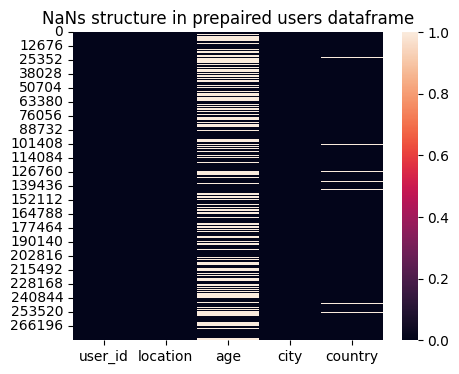

In [38]:
plt.figure(figsize=(5, 4))
sns.heatmap(df_users.isna())
plt.title('NaNs structure in prepaired users dataframe')
plt.show()


# EDA

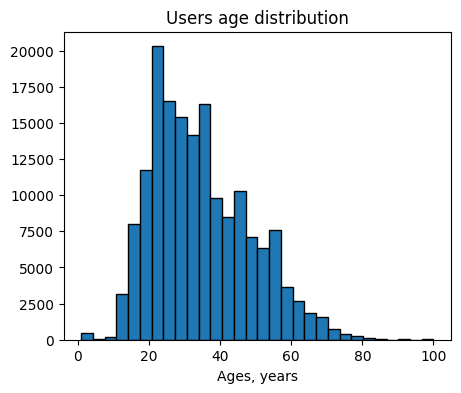

In [73]:
plt.figure(figsize=(5, 4))
plt.hist(df_users['age'], bins=30, edgecolor='black')
plt.title('Users age distribution')
plt.xlabel('Ages, years')
plt.show()

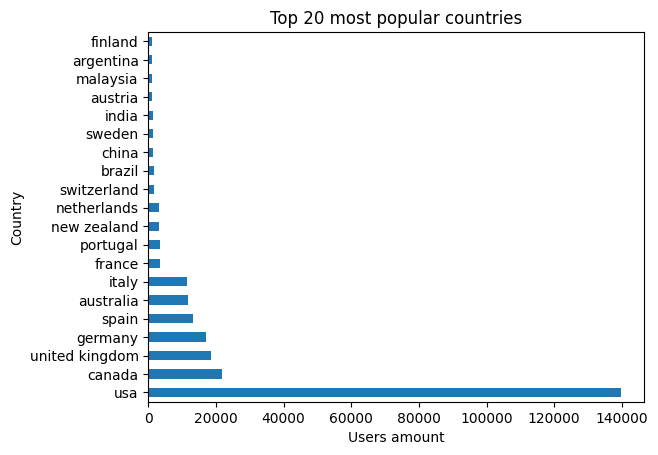

In [40]:
plt.title("Top 20 most popular countries")
df_users['country'].value_counts().head(20).plot.barh()
plt.ylabel('Country')
plt.xlabel('Users amount')
plt.show()

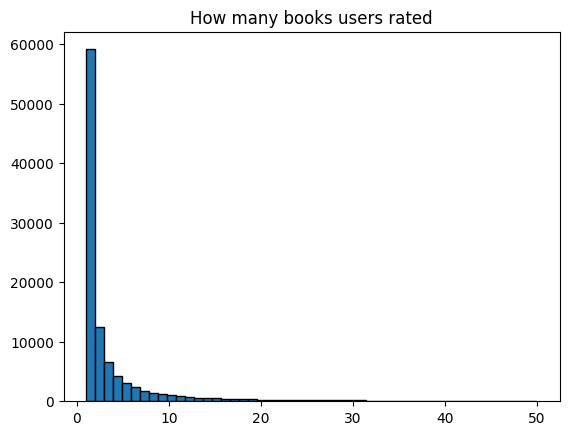

In [69]:
user_intercation_count = df_ratings['user_id'].value_counts()
plt.title('How many books users rated')
plt.hist(
    user_intercation_count[user_intercation_count <= 50], 
    bins=50, 
    edgecolor='black'
)
plt.show()

In [75]:
# Top 30 the most popular books
df_books.loc[df_books['isbn'].isin(df_ratings['isbn'].value_counts().head(30).index), ['isbn', 'title', 'author', 'year']]

,isbn,title,author,year
26,0971880107,Wild Animus,Rich Shapero,2004.0
67,0804106304,The Joy Luck Club,Amy Tan,1994.0
118,0671027360,Angels &amp; Demons,Dan Brown,2001.0
229,0452282152,Girl with a Pearl Earring,Tracy Chevalier,2001.0
302,044023722X,A Painted House,John Grisham,2001.0
352,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003.0
404,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002.0
452,044021145X,The Firm,John Grisham,1992.0
481,0671021001,She's Come Undone (Oprah's Book Club),Wally Lamb,1998.0
518,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998.0
